# Calibrated posteriors via honesty

Example adopted from the scikit-learn [example](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) on probability calibration.

In [1]:
import numpy as np

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

from proglearn.forest import UncertaintyForest

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [43]:
# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9,
                                                    random_state=42)

UF:
	Brier: 0.094
	Precision: 0.861
	Recall: 0.879
	F1: 0.870

RF:
	Brier: 0.095
	Precision: 0.859
	Recall: 0.877
	F1: 0.868

RF Isotonic:
	Brier: 0.093
	Precision: 0.855
	Recall: 0.892
	F1: 0.873

RF Sigmoid:
	Brier: 0.094
	Precision: 0.862
	Recall: 0.882
	F1: 0.872



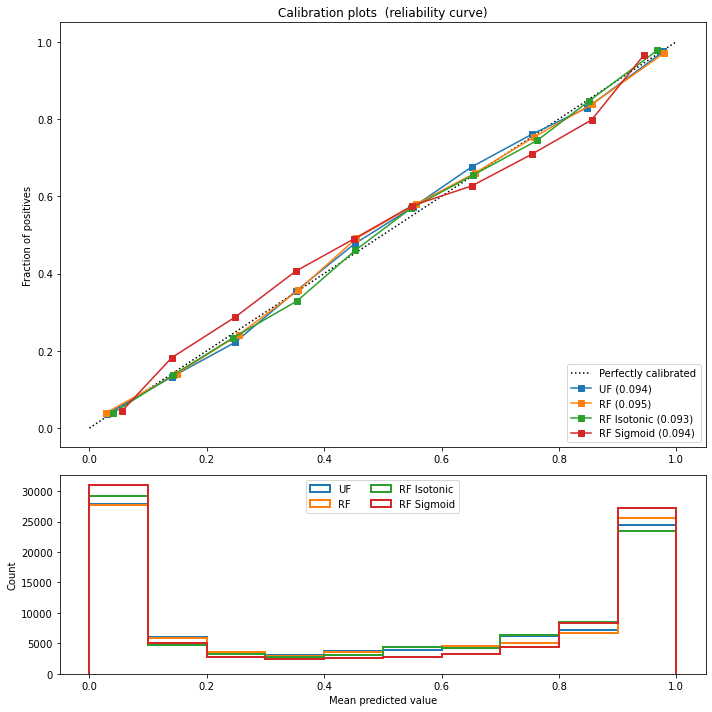

In [44]:
# RandomForestClassifier with no calibration as baseline
rf = RandomForestClassifier()

# Calibrated with isotonic calibration
isotonic = CalibratedClassifierCV(RandomForestClassifier(), cv=2, method='isotonic')

# Calibrated with sigmoid calibration
sigmoid = CalibratedClassifierCV(RandomForestClassifier(), cv=2, method='sigmoid')

# Uncertainty forest
uf = UncertaintyForest(kappa=10)

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(uf, 'UF'),
                  (rf, 'RF'),
                  (isotonic, 'RF Isotonic'),
                  (sigmoid, 'RF Sigmoid')]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    prob_pos = clf.predict_proba(X_test)[:, 1]

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (name, clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [34]:
n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = datasets.make_blobs(n_samples=n_samples, centers=centers, shuffle=False,
                  random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

# Random forest with no calibration
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
prob_pos_rf = rf.predict_proba(X_test)[:, 1]

# Calibrated with isotonic calibration
rf_isotonic = CalibratedClassifierCV(RandomForestClassifier(), cv=2, method='isotonic')
rf_isotonic.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_isotonic = rf_isotonic.predict_proba(X_test)[:, 1]

# Calibrated with sigmoid calibration
rf_sigmoid = CalibratedClassifierCV(RandomForestClassifier(), cv=2, method='sigmoid')
rf_sigmoid.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_sigmoid = rf_sigmoid.predict_proba(X_test)[:, 1]

In [24]:
# Uncertainty forest
uf = UncertaintyForest(kappa=0.3)
uf.fit(X_train, y_train)
prob_pos_uf = uf.predict_proba(X_test)[:, 1]

print("Brier scores: (the smaller the better)")

rf_score = brier_score_loss(y_test, prob_pos_rf, sample_weight=sw_test)
print("No calibration: %1.3f" % rf_score)

rf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic,
                                      sample_weight=sw_test)
print("With isotonic calibration: %1.3f" % rf_isotonic_score)

rf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid,
                                     sample_weight=sw_test)
print("With sigmoid calibration: %1.3f" % rf_sigmoid_score)

uf_score = brier_score_loss(y_test, prob_pos_uf, sample_weight=sw_test)
print("Uncertainty forest: %1.3f" % uf_score)

Brier scores: (the smaller the better)
No calibration: 0.098
With isotonic calibration: 0.085
With sigmoid calibration: 0.095
Uncertainty forest: 0.085


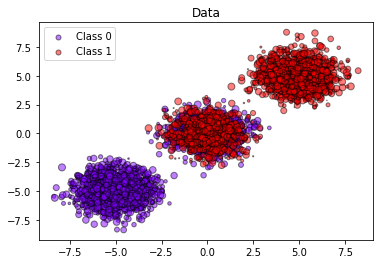

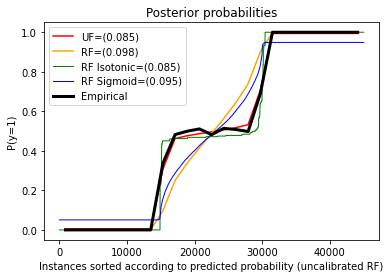

In [25]:
# #############################################################################
# Plot the data and the predicted probabilities
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50,
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()
order = np.lexsort((prob_pos_uf, ))
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         prob_pos_uf[order].reshape(25, -1).mean(1), 'r', label='UF=(%1.3f)' % uf_score)
order = np.lexsort((prob_pos_rf, ))
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         prob_pos_rf[order].reshape(25, -1).mean(1), 'orange', label='RF=(%1.3f)' % rf_score)
order = np.lexsort((prob_pos_isotonic, ))
plt.plot(prob_pos_isotonic[order], 'g', linewidth=1,
         label='RF Isotonic=(%1.3f)' % rf_isotonic_score)
order = np.lexsort((prob_pos_sigmoid, ))
plt.plot(prob_pos_sigmoid[order], 'b', linewidth=1,
         label='RF Sigmoid=(%1.3f)' % rf_sigmoid_score)
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated RF)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Posterior probabilities")

plt.show()